# ADS 599 Team 7 Final Project

## Image Classification For Pneumonia Detection using Chest X-Ray Images

#### University of San Diego - Applied Data Science
#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

#### Github Link: https://github.com/dingyiduan7/ADS599_Capstone_Image_Recognition

### Load the necessary packages

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from random import randint

from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tensorflow import keras  
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, MaxPooling2D, Activation, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,confusion_matrix

## Stage 1: Data Loading and Exploratory Data Analysis (EDA)

Display all our datasets/folders

In [2]:
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/train"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/val"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/test"))

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


Here we have three folders of train, val and test sets.
Each folder contains two subfolders of "NORMAL" and "PNEUMONIA" images.

In [3]:
# set the path for all three datasets
data_dir = Path("D:/USD-ADS_graduate/ADS-599/chest_xray/")
train_dir = data_dir/"train"
val_dir = data_dir/"val"
test_dir = data_dir/"test"

In [4]:
# set the path for all three datasets
#data_dir = Path("C:/Users/abby0/OneDrive/Desktop/MSADS/ADS-599 Capstone/Project/chest_xray/")
#train_dir = data_dir/"train"
#val_dir = data_dir/"val"
#test_dir = data_dir/"test"

In [5]:
# function to load the data into dataframes from each folder and label them

def load_data(data_path):
    normal_dir = data_path/"NORMAL"
    pneum_dir = data_path/"PNEUMONIA"
    
    # images are in .jpeg format
    normal_img = normal_dir.glob('*.jpeg')
    pneum_img = pneum_dir.glob('*.jpeg')
    
    img_data = []
    img_label = []
    
    for img in normal_img:
        img_data.append(img)
        img_label.append('NORMAL')
        
    for img in pneum_img:
        img_data.append(img)
        img_label.append('PNEUMONIA')
    df = pd.DataFrame(img_data,columns=['images'])
    df['label'] = img_label
    df = df.reset_index(drop=True)
    
    return df

In [6]:
df_train = load_data(train_dir)
print(df_train.sample(10))

                                                 images      label
2770  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
4748  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
2885  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
5171  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
654   D:\USD-ADS_graduate\ADS-599\chest_xray\train\N...     NORMAL
1656  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
4214  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA
683   D:\USD-ADS_graduate\ADS-599\chest_xray\train\N...     NORMAL
941   D:\USD-ADS_graduate\ADS-599\chest_xray\train\N...     NORMAL
2969  D:\USD-ADS_graduate\ADS-599\chest_xray\train\P...  PNEUMONIA


Create all the dataframes seprately to avoid data leakage

In [7]:
df_val = load_data(val_dir)
df_test = load_data(test_dir)
print('The training data has a shape of:',df_train.shape)
print('The validate data has a shape of:',df_val.shape)
print('The test data has a shape of:',df_test.shape)

The training data has a shape of: (5216, 2)
The validate data has a shape of: (16, 2)
The test data has a shape of: (624, 2)


Let's check to see whether the training set is balanced.

<AxesSubplot:title={'center':'Training Data Label Distribution'}>

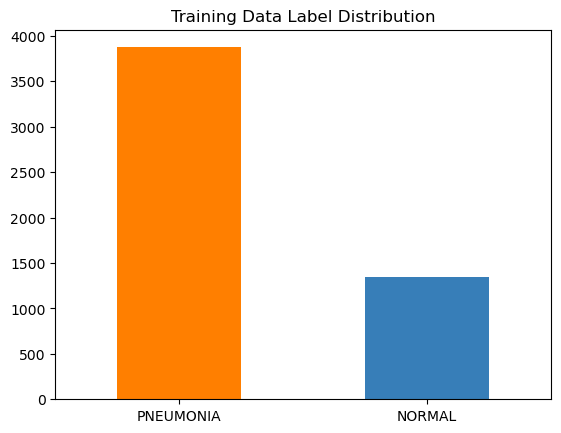

In [8]:
# using colorblind friendly colors
df_train['label'].value_counts().plot(kind='bar',rot=0,title="Training Data Label Distribution",color=['#ff7f00','#377eb8'])

As many real life problems, our training data is obviously imbalanced. We could perform oversampling to balance the dataset.

In [9]:
# Oversampling
df_train['images'][0]

WindowsPath('D:/USD-ADS_graduate/ADS-599/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

We can also look at our images to see how different are normal and pneumonia on x-ray

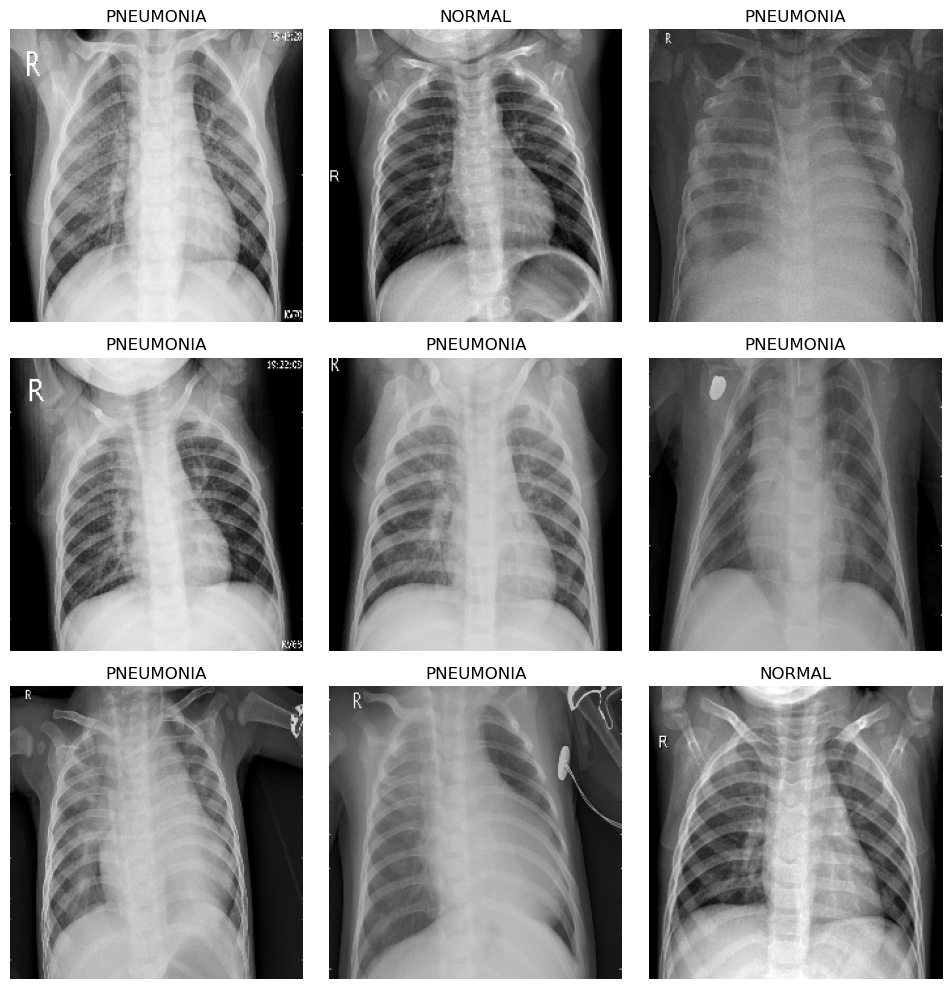

In [10]:
plt.figure(figsize=(10,10))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    j = randint(0, len(df_train))
    img_path = str(df_train['images'][j])
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224))
    plt.title(df_train['label'][j])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

From the raw images we can see that it can be hard for our bare eyes to tell the difference.

## Stage 2: Data Cleaning and Preprocessing

### Image Formatting/ Image Augmentation


Reference: https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

Let's take a random sample from our training set and look at how different image formatting and augmentation will take effect on our images.

(-0.5, 223.5, 223.5, -0.5)

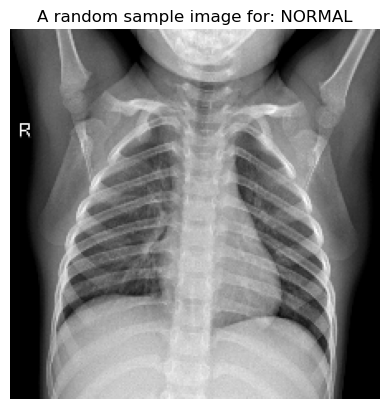

In [11]:
sample_ind = randint(0, len(df_train))
sample_path= str(df_train['images'][sample_ind])
sample_img = cv2.imread(sample_path)
sample_img = cv2.resize(sample_img,(224,224))
plt.title('A random sample image for: %s'%df_train['label'][sample_ind])
plt.imshow(sample_img)
plt.axis('off')

In [12]:
def original(img):
    return img

#### 1. Resizing 
Resize the image to a given length and width

In [13]:
def resizing(img):
    res_img = cv2.resize(img, (50,50)) # using 300 as an arbitrary dimension
    return res_img

#### 2. Gray Scaling
The image will be converted to gray scale (range of gray shades from white to black) the computer will assign each pixel a value based on how dark it is. All the numbers are put into an array and the computer does computations on that array.

In [14]:
def gray_scale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

#### 3. Reflection/Flip
flip images horizontally and vertically. Some frameworks do not provide function for vertical flips. But, a vertical flip is equivalent to rotating an image by 180 degrees and then performing a horizontal flip.

In [15]:
def ref_flip(img):
    flip_img = cv2.flip(img,1)
    return flip_img

#### 4. Gaussian Blurring
Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise.

In [16]:
def gau_blur(img):
    blur_img = ndimage.gaussian_filter(img, sigma= 5.11)
    return blur_img

#### 5. Histogram Equalization
Histogram equalization is another image processing technique to increase global contrast of an image using the image intensity histogram. This method needs no parameter, but it sometimes results in an unnatural looking image.

In [17]:
def hist_eq(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_img= cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_img

#### 6. Rotation
Rotating an image might not preserve its original dimensions (depending on what angle you choose to rotate it with )

In [18]:
def rotation(img):
    rows,cols = img.shape[0],img.shape[1]
    randDeg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
    rot_img = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT)
    return rot_img 

#### 7. Channel Conversion
Some images are in  greyscale (1 channel), therefore convert them to 3 channel

In [19]:
def channel_con(img):
    if img.shape[2]==1:
        img = dstack([img,img,img])
    return img 

#### 8. Color Conversion
Images read using cv2 are in BGR format(by default), convert it to RGB.

In [20]:
def color_con(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

There we have it, a series of image augmentation and processing that enables us to modify the images for training to improve the model performance.
#### Augmentation Comparison

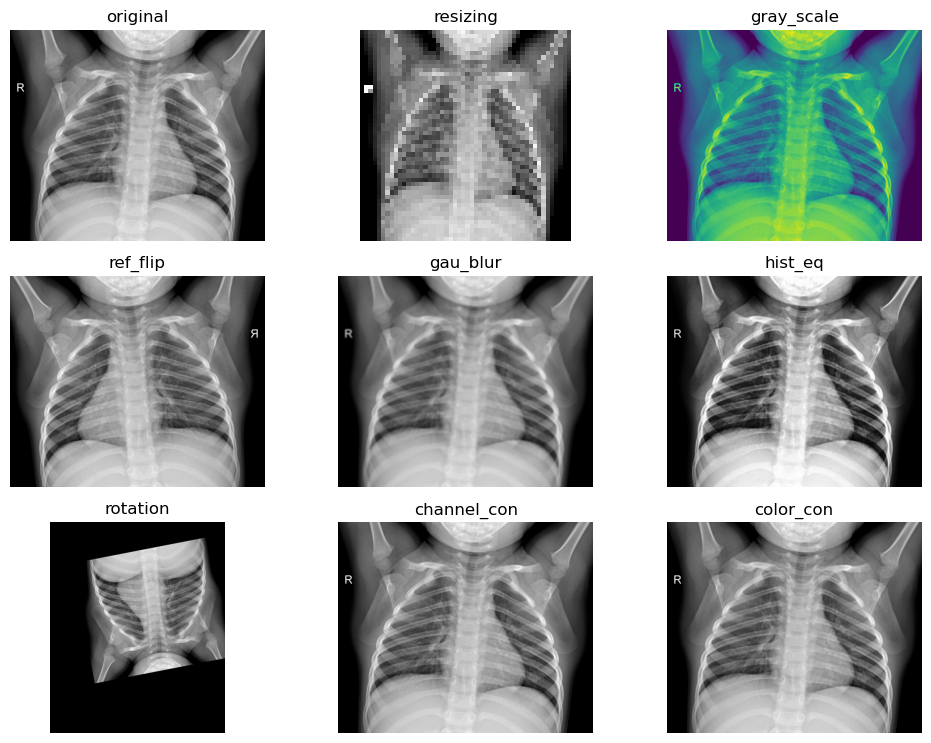

In [21]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]

plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(4,3,img_aug.index(aug)+1)
    sample_img = cv2.imread(sample_path)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

From the comparison we can see that:

- resizing changes the pixel amount of the images, causing it to be higher or lower resolved;
- grey scaling is to make sure our images have one channel.
- relection/flip is also unnecessary since the x-ray images has a "right" reference, it may be harmful for our predictions;
- gaussion blurrying doesn't seem to help us neither by blurring the images;
- histogram equalization increases the constrast of our images, but also changes the color channel to 3.
- rotation causes the disortion of our image size and quality, may not be useful for us
- channel conversion is not needed since our grey scaled x-rays already has one channel in them.
- color conversion does not cause an impact on our images but it is nice to make sure they all has the same channel order.

#### Image when all augmentation is performed.

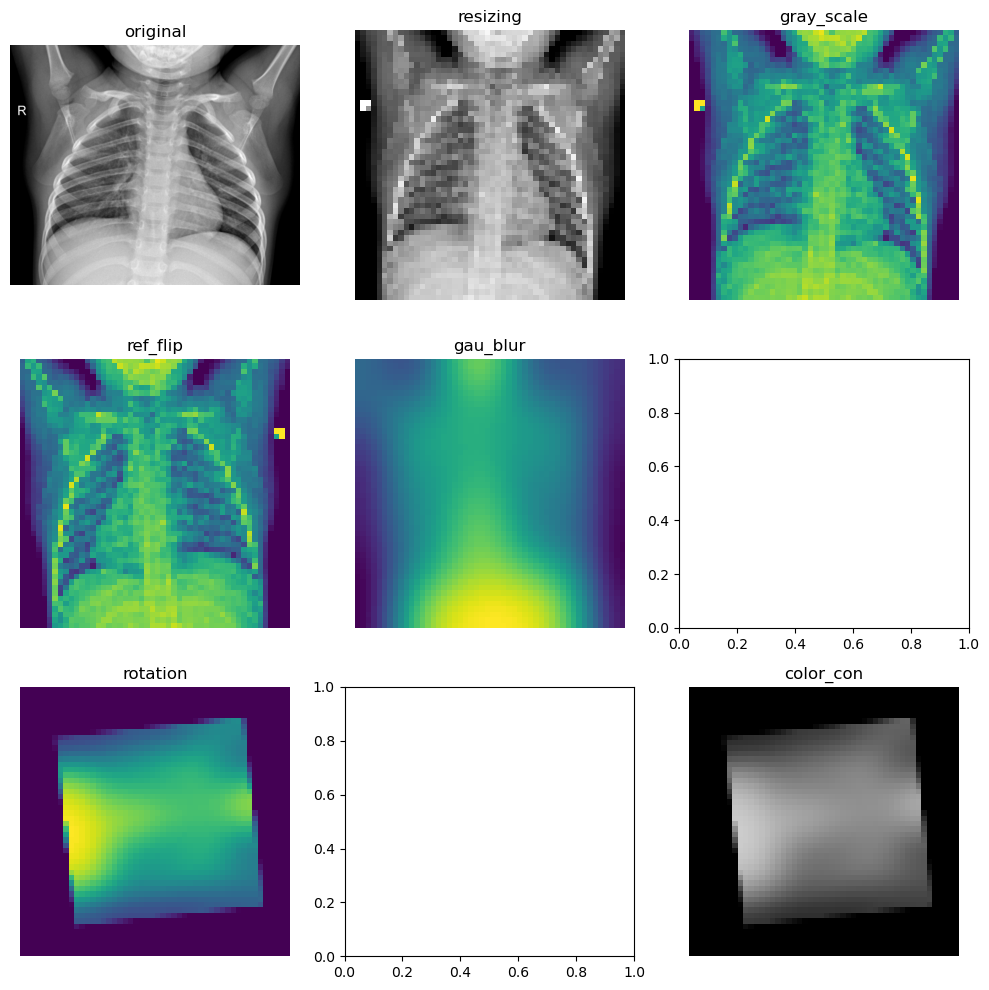

In [22]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    try:
        ax = plt.subplot(3,3,img_aug.index(aug)+1)
        sample_img = aug(sample_img)
        plt.title(aug.__name__)
        plt.imshow(sample_img)
        plt.axis('off')
        plt.tight_layout()  
    except:
        pass

Obviously we cannot perform all processing steps to the same image all together, it is only rational for us to find the most optimal way to prepare the image.

Let's try with the following augmentation:
- resizing to 224 x 224
- gray scaling
- histogram equalization

In [23]:
# we'll resize the image to better quality
def resizing2(img):
    res_img = cv2.resize(img, (224,224)) # using 224 for better pixel size
    return res_img

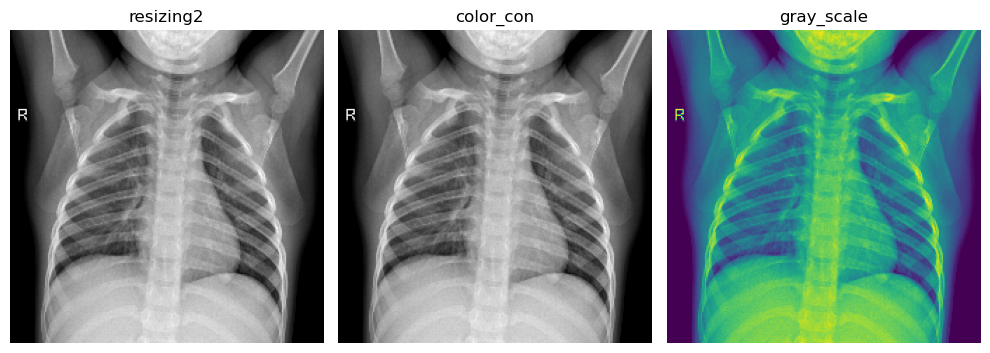

In [24]:
img_aug = [resizing2, color_con, gray_scale,]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(1, 3, img_aug.index(aug)+1)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

This would be a better processing procedure, hence we set our pipeline to be such.

In [25]:
# pipeline implementation
def prepare(path, pipeline) : 
    img = cv2.imread(str(path))
    
    for transform in pipeline : 
        img = transform(img)
        
    return img

pipeline = [resizing2, color_con, gray_scale,]

### Training data

In [26]:
df_train['images'] = df_train['images'].apply(prepare,pipeline = pipeline)

In [27]:
df_train.head()

,images,label
0,"[[24, 20, 19, 17, 17, 28, 56, 58, 64, 65, 72, ...",NORMAL
1,"[[14, 24, 25, 31, 34, 37, 36, 43, 47, 45, 49, ...",NORMAL
2,"[[0, 0, 0, 8, 18, 27, 32, 35, 44, 45, 50, 57, ...",NORMAL
3,"[[40, 46, 47, 55, 55, 58, 61, 69, 73, 78, 81, ...",NORMAL
4,"[[77, 77, 62, 57, 50, 39, 29, 28, 28, 25, 20, ...",NORMAL


In [28]:
for i in range(len(df_train)):
    df_train['images'][i] = df_train['images'][i].astype(np.float32)/255
    
df_train['label'] = df_train['label'].astype(str)
df_train['label'] = df_train['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [29]:
df_train.sample(20)

,images,label
1464,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
5195,"[[0.0, 0.0, 0.007843138, 0.011764706, 0.015686...",1
3183,"[[0.76862746, 0.7529412, 0.77254903, 0.7647059...",1
4056,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0156862...",1
1664,"[[0.10980392, 0.105882354, 0.10980392, 0.10980...",1
2821,"[[0.12156863, 0.12156863, 0.12156863, 0.121568...",1
1757,"[[0.80784315, 0.79607844, 0.79607844, 0.788235...",1
4895,"[[0.93333334, 0.8980392, 0.89411765, 0.8470588...",1
2057,"[[0.03137255, 0.019607844, 0.011764706, 0.0, 0...",1
5047,"[[0.023529412, 0.14509805, 0.15294118, 0.15686...",1


In [30]:
x_train = np.array([df_train['images'][i] for i in range(len(df_train))])
y_train = np.array(df_train['label'])

##### Reshape data for model without sequential 

Train dataset consists 5216 images, and each image was resize to 224 x 224 pixels, which implies each image in the dataset is represented by 224 x 224 = 50,176 integers.

In [31]:
x_train.shape

(5216, 224, 224)

In [32]:
x_train_2 = x_train.reshape((x_train.shape[0], 50176))

In [33]:
print(pd.DataFrame(x_train_2).shape)
pd.DataFrame(x_train_2).head(3)

(5216, 50176)


,0,1,2,3,4,5,6,7,8,9,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,0.094118,0.078431,0.074510,0.066667,0.066667,0.109804,0.219608,0.227451,0.250980,0.254902,...,0.407843,0.415686,0.419608,0.419608,0.427451,0.427451,0.435294,0.423529,0.443137,0.431373
1,0.054902,0.094118,0.098039,0.121569,0.133333,0.145098,0.141176,0.168627,0.184314,0.176471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.031373,0.070588,0.105882,0.125490,0.137255,0.172549,0.176471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765


In [34]:
le = LabelEncoder()
y_train_2 = le.fit_transform(df_train['label'])

### Validation data

In [35]:
df_val['images'] = df_val['images'].apply(prepare,pipeline=pipeline)

In [36]:
for i in range(len(df_val)):
    df_val['images'][i] = df_val['images'][i].astype(np.float32)/255
    
df_val['label'] = df_val['label'].astype(str)
df_val['label'] = df_val['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [37]:
x_val = np.array([df_val['images'][i] for i in range(len(df_val))])
y_val = np.array(df_test['label'])

##### Reshape Validate Data

In [38]:
x_val_2 = x_val.reshape((x_val.shape[0], 50176))
y_val_2 = le.fit_transform(df_val['label'])

### Test data

In [39]:
df_test['images'] = df_test['images'].apply(prepare,pipeline=pipeline)

In [40]:
for i in range(len(df_test)):
    df_test['images'][i] = df_test['images'][i].astype(np.float32)/255
    
df_test['label'] = df_test['label'].astype(str)
df_test['label'] = df_test['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [41]:
x_test = np.array([df_test['images'][i] for i in range(len(df_test))])
y_test = np.array(df_test['label'])

##### Reshape Test Data

In [42]:
x_test_2 = x_test.reshape((x_test.shape[0], 50176))
y_test_2 = le.fit_transform(df_test['label'])

## Stage 3: Model Definition and Training

### Sequential Setup

In [43]:
model = Sequential()
model.add(Conv2D(16,(5,5), padding='valid',input_shape = (224, 224, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))
model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      416       
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_1 (Activation)   (None, 106, 106, 32)      0         
                                                        

In [45]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 82ms/step


### General Macine Learning Classifiers

##### SVM

In [46]:
svm = SVC(kernel='rbf')
svm.fit(feat_train,y_train)
svm.score(feat_test,y_test)

0.625

Without sequential 

In [47]:
svm = SVC(kernel='rbf')
svm.fit(x_train_2,y_train_2)
svm.score(x_test_2,y_test_2)

0.7580128205128205

##### KNN

In [48]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 88ms/step


In [49]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(feat_train,y_train)
knn.score(feat_test,y_test)

0.6137820512820513

Without sequential 

In [50]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(x_train_2,y_train_2)
knn.score(x_test_2,y_test_2)

0.7403846153846154

##### Decision Tree

In [51]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 86ms/step


In [52]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(feat_train,y_train)
dt.score(feat_test,y_test)

0.625

Without sequential 

In [53]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(x_train_2,y_train_2)
dt.score(x_test_2,y_test_2)

0.7227564102564102

##### Random Forest

In [54]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 80ms/step


In [55]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(feat_train,y_train)
rf.score(feat_test,y_test)

0.5961538461538461

Without sequential 

In [56]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(x_train_2,y_train_2)
rf.score(x_test_2,y_test_2)

0.7564102564102564

### Deep Learning Models

##### CNN (WIP)

In [57]:
batch_size = 100
epochs= 100

optimizer = keras.optimizers.RMSprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, 
              metrics = ['accuracy','precision', 'recall'])

C:\Users\Dingyi Duan\AppData\Roaming\Python\Python38\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


##### yolo

##### vgg16

##### ResNet50

##### EfficientNet

## Stage 4: Model performance and evaluation

## Stage 5: Model Deployment